The dataset has future merchant transaction activity, for merchants that start over a 2 year period
(2033-2034). The data spans from 1/1/33 through 12/31/34. Although the data is made up, you can
consider this to be a random sample of future merchants using Stripe. Each observation is a
transaction amount in cents. If the merchant stops processing with Stripe, then they would no
longer appear.

Question:
1. identify different kinds of businesses in the sample
2. identifying and predicting churn (stop processing)



In [238]:
#import data
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
trans = pd.read_csv('D:/pythonProject/stripe/takehome_ds_written.csv', index_col=0)
trans.head()
print (trans.isnull().sum())
print ("number of row: " + str(len(trans.merchant)))
print ("number of merchant: " + str(len(set(trans.merchant))))
trans.dtypes

merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64
number of row: 1513719
number of merchant: 14351


merchant               object
time                   object
amount_usd_in_cents     int64
dtype: object

1. The dataset includes 1,513,719 records and 3 field.
2. No null data.
3. Including 14351 merchants.
4. From the first 5 rows of data, we can find that there are three columns of data, merchant ID, time, amount_used_in_cents.
Because the type of time is the object, we should change time into the datatime type.

In [239]:
#change data type of time, extract year, month and day from time.
trans['dates'] = pd.to_datetime(trans.time)
trans['day'] = trans.dates.astype('M8[D]')  #day
trans['month'] = trans.dates.astype('M8[M]')  #month
trans['year'] = trans.dates.astype('M8[Y]')  #year
trans.dtypes
trans.head()

,merchant,time,amount_usd_in_cents,dates,day,month,year
1,faa029c6b0,2034-06-17 23:34:14,6349,2034-06-17 23:34:14,2034-06-17,2034-06-01,2034-01-01
2,ed7a7d91aa,2034-12-27 00:40:38,3854,2034-12-27 00:40:38,2034-12-27,2034-12-01,2034-01-01
3,5608f200cf,2034-04-30 01:29:42,789,2034-04-30 01:29:42,2034-04-30,2034-04-01,2034-01-01
4,15b1a0d61e,2034-09-16 01:06:23,4452,2034-09-16 01:06:23,2034-09-16,2034-09-01,2034-01-01
5,4770051790,2034-07-22 16:21:42,20203,2034-07-22 16:21:42,2034-07-22,2034-07-01,2034-01-01


In [240]:
#We should see the statistics for data
trans.describe()

,amount_usd_in_cents
count,1.513719e+06
mean,1.548466e+04
std,6.161886e+04
min,2.010000e+02
25%,3.215000e+03
50%,6.104000e+03
75%,1.260600e+04
max,2.592028e+07


<AxesSubplot:ylabel='Frequency'>

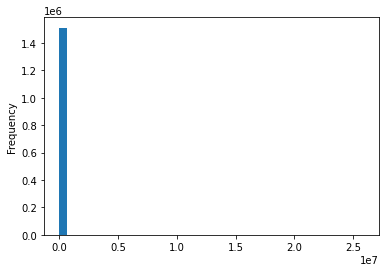

In [241]:
trans['amount_usd_in_cents'].plot.hist(bins= 40)


From the plot, most amount of transactions are less than 5*10^6

For the first problem, we want to find different kinds of businesses in the sample, which means
finding the classifications for the merchants. This is a clustering problem because we didn't have
the classification of the merchant.
I want to use the simplest and most popular unsupervised machine learning algorithms the k-means model to do the clustering,
I need some variables to do the k-means algorithm, I calculate some statistics to be the variable, like mean, median, maximal,
minimal, number, range, std, the sum for the amount of transaction for each merchant in one transaction. Also, the number of transactions
for every season, how many transactions for every month.
1. Mean
2. Median
3. Maximal
4. Minimal
5. Count of transactions for one merchant
6. Standard Deviation
7. Sum of the amount of transaction for one merchant
8. Length (how many months this merchant processing)
9. 2033-S1 to 2034-S4 (the amount of transactions for every season)
(S1:1-3 month, S2:4-6 month, S3:7-9 month, S4:10-12 month)
10. Num_2033-s1 to Num_2034-S4 (the number of transaction for every season)







In [242]:
#calculate statistics for variables
metric = ('mean', 'median', 'max', 'min', 'count', 'std', 'sum')
stat = trans.groupby('merchant')['amount_usd_in_cents'].agg(metric).reset_index()
count_month = trans.groupby(['merchant','month'])['amount_usd_in_cents'].count().reset_index()
sum_month = trans.groupby(['merchant','month'])['amount_usd_in_cents'].sum().reset_index()
stat.columns = ['merchant','Mean', 'Median', 'Max', 'Min', 'Num', 'Std', 'Sum']
print(stat.isnull().sum())
stat = stat.fillna(0) #use 0 to fill na value for std
print(stat.isnull().sum())


merchant       0
Mean           0
Median         0
Max            0
Min            0
Num            0
Std         1666
Sum            0
dtype: int64
merchant    0
Mean        0
Median      0
Max         0
Min         0
Num         0
Std         0
Sum         0
dtype: int64


In [243]:
count_month = count_month.pivot(index='merchant', columns='month', values='amount_usd_in_cents') #number for every month
sum_month = sum_month.pivot(index='merchant', columns='month', values='amount_usd_in_cents') #amount for every month
count_month.columns = [month for month in count_month.columns.strftime('%Y-%m')] #change the title
sum_month.columns = [month for month in sum_month.columns.strftime('%Y-%m')] #change the title


In [244]:
#Compute the length variable
count_month['Length'] = count_month.notnull().sum(axis=1)
count_month = count_month.fillna(0)
sum_month = sum_month.fillna(0)
count_month.head()


,2033-01,2033-02,2033-03,2033-04,2033-05,2033-06,2033-07,2033-08,2033-09,2033-10,...,2034-04,2034-05,2034-06,2034-07,2034-08,2034-09,2034-10,2034-11,2034-12,Length
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0002d07bba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3
00057d4302,0.0,0.0,0.0,0.0,17.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
000bcff341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
000ddbf0ca,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [245]:
#Sum to season
count_month['2033-S1'] = count_month['2033-01'] + count_month['2033-02'] + count_month['2033-03']
count_month['2033-S2'] = count_month['2033-04'] + count_month['2033-05'] + count_month['2033-06']
count_month['2033-S3'] = count_month['2033-07'] + count_month['2033-08'] + count_month['2033-09']
count_month['2033-S4'] = count_month['2033-10'] + count_month['2033-11'] + count_month['2033-12']
count_month['2034-S1'] = count_month['2034-01'] + count_month['2034-02'] + count_month['2034-03']
count_month['2034-S2'] = count_month['2034-04'] + count_month['2034-05'] + count_month['2034-06']
count_month['2034-S3'] = count_month['2034-07'] + count_month['2034-08'] + count_month['2034-09']
count_month['2034-S4'] = count_month['2034-10'] + count_month['2034-11'] + count_month['2034-12']
sum_month['Num_2033-S1'] = sum_month['2033-01'] + sum_month['2033-02'] + sum_month['2033-03']
sum_month['Num_2033-S2'] = sum_month['2033-04'] + sum_month['2033-05'] + sum_month['2033-06']
sum_month['Num_2033-S3'] = sum_month['2033-07'] + sum_month['2033-08'] + sum_month['2033-09']
sum_month['Num_2033-S4'] = sum_month['2033-10'] + sum_month['2033-11'] + sum_month['2033-12']
sum_month['Num_2034-S1'] = sum_month['2034-01'] + sum_month['2034-02'] + sum_month['2034-03']
sum_month['Num_2034-S2'] = sum_month['2034-04'] + sum_month['2034-05'] + sum_month['2034-06']
sum_month['Num_2034-S3'] = sum_month['2034-07'] + sum_month['2034-08'] + sum_month['2034-09']
sum_month['Num_2034-S4'] = sum_month['2034-10'] + sum_month['2034-11'] + sum_month['2034-12']
count_season = count_month.iloc[:,24:35]
sum_season = sum_month.iloc[:,24:34]
count_season = count_season.reset_index()
sum_season = sum_season.reset_index()


In [246]:
#combine to one dataframe
stat = stat.merge(count_season, how = 'inner', on = 'merchant')
stat = stat.merge(sum_season, how = 'inner', on = 'merchant')


In [247]:
#create a new dataframe for variables
title = ['merchant','Mean', 'Median', 'Max', 'Min', 'Num', 'Std', 'Sum', 'Length',
         '2033-S1', '2033-S2', '2033-S3','2033-S4', '2034-S1', '2034-S2', '2034-S3', '2034-S4',
         'Num_2033-S1', 'Num_2033-S2', 'Num_2033-S3', 'Num_2033-S4', 'Num_2034-S1', 'Num_2034-S2', 'Num_2034-S3', 'Num_2034-S4']
dataset = pd.DataFrame(index=range(0, len(set(trans.merchant))),columns = title)
dataset = dataset.fillna(stat)
print(dataset.isnull().sum())



merchant       0
Mean           0
Median         0
Max            0
Min            0
Num            0
Std            0
Sum            0
Length         0
2033-S1        0
2033-S2        0
2033-S3        0
2033-S4        0
2034-S1        0
2034-S2        0
2034-S3        0
2034-S4        0
Num_2033-S1    0
Num_2033-S2    0
Num_2033-S3    0
Num_2033-S4    0
Num_2034-S1    0
Num_2034-S2    0
Num_2034-S3    0
Num_2034-S4    0
dtype: int64


1.0142645755203565e+17
               Mean  labels
0            3379.0       0
1           22319.5       0
2       1054.321429       0
3            7826.0       0
4           10299.0       0
...             ...     ...
14346       14525.2       0
14347   5313.509434       0
14348  11840.901235       0
14349   5311.333333       0
14350  11602.065217       0

[14351 rows x 2 columns]
   labels  merchant
0       0     12383
1       1        60
2       2      1307
3       3         1
4       4        23
5       5       157
6       6         1
7       7         1
8       8         1
9       9       417


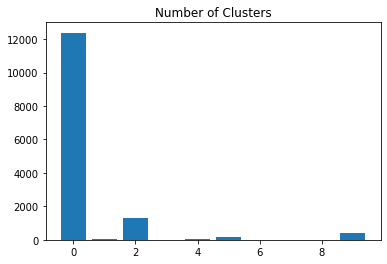

In [248]:
# K-means clustering
kmeans = KMeans(n_clusters = 10) #10 clusters
kmeans.fit(dataset.iloc[:,1:])
print(kmeans.inertia_)
dataset['labels'] = kmeans.labels_ # classification for merchant
print(dataset.iloc[:,[1,25]])
cluster = dataset.groupby('labels').count().reset_index()
cluster = cluster.iloc[:,:2]
print(cluster)
plt.bar(cluster.iloc[:,0], cluster.iloc[:,1])
plt.title("Number of Clusters")
plt.show()

From the result of K-means clustering, we can get the different types of merchants, after analyzing the feature for each group of the merchant,
we can define which group of the merchant belongs to some type of business. Also, we can apply different strategies for a different type
of business, helping the company utilize resource maximal.



For the second, identifying and predicting churn (stop processing)

To identify the churn, we should define how many days or months the merchant stop processing can be defined as churn.
If we define the merchant stop processing longer than 30 days as churn, we find some merchants may restart to processing.
So I define churn for a natural year, from 01-01 to 12-31. If merchant restart processing in one natural year,
then tag as not churn

We want to use these data to predict churn, first is separate data into two sets, one is a train set, another is a test
set. we use a train set to train the model and evaluate our model by implementing it into the test set.
After we define the churn, let 0 present no churn, 1 present churn.
I want to random forest model to be trained and predict the test set and calculate the accuracy.


In [249]:
#Seprate the data into two natural year
stat2 = trans.groupby(['merchant','year'])['amount_usd_in_cents'].agg(metric).reset_index()
stat2.columns = ['merchant', 'Year', 'Mean', 'Median', 'Max', 'Min', 'Num', 'Std', 'Sum']
stat2.head()
print(stat2.isnull().sum())
stat2 = stat2.fillna(0)
print(stat2.isnull().sum())

merchant       0
Year           0
Mean           0
Median         0
Max            0
Min            0
Num            0
Std         2617
Sum            0
dtype: int64
merchant    0
Year        0
Mean        0
Median      0
Max         0
Min         0
Num         0
Std         0
Sum         0
dtype: int64


In [250]:
count_month2 = trans.groupby(['merchant', 'year', 'month'])['amount_usd_in_cents'].count().reset_index()
sum_month2 = trans.groupby(['merchant', 'year', 'month'])['amount_usd_in_cents'].sum().reset_index()

In [251]:
#Define the churn and tag as 0 and 1 into type variable
max_day = trans.groupby(['merchant', 'year'])['day'].max().reset_index()
min_day = trans.groupby(['merchant', 'year'])['day'].min().reset_index()
max_day.columns = ['merchant', 'year', 'day']
max_day['type'] = np.where( ((max_day['day'] < datetime(2033, 12, 31)) & (max_day['year'] == datetime(2033, 1, 1)))
                            | ((max_day['day'] < datetime(2034, 12, 31)) & (max_day['year'] == datetime(2034, 1, 1))) ,1,0)
max_day.columns = ['merchant', 'Year', 'Day', 'Type']
max_day.head()

,merchant,Year,Day,Type
0,0002b63b92,2033-01-01,2033-05-16,1
1,0002d07bba,2034-01-01,2034-12-15,1
2,00057d4302,2033-01-01,2033-08-04,1
3,000bcff341,2033-01-01,2033-08-09,1
4,000ddbf0ca,2033-01-01,2033-06-02,1


In [252]:
#calculate the length variable
count_month2 = count_month2.pivot(index = ['merchant', 'year'], columns = 'month', values = 'amount_usd_in_cents')
sum_month2 = sum_month2.pivot(index = ['merchant', 'year'], columns = 'month', values = 'amount_usd_in_cents')
count_month2.columns = [month for month in count_month2.columns.strftime('%Y-%m')]
sum_month2.columns = [month for month in sum_month2.columns.strftime('%Y-%m')]
count_month2['Length'] = count_month2.notnull().sum(axis=1)
count_month2 = count_month2.fillna(0)
sum_month2 = sum_month2.fillna(0)
count_month2.head()
sum_month2.head()

,,2033-01,2033-02,2033-03,2033-04,2033-05,2033-06,2033-07,2033-08,2033-09,2033-10,...,2034-03,2034-04,2034-05,2034-06,2034-07,2034-08,2034-09,2034-10,2034-11,2034-12
merchant,year,,,,,,,,,,,,,,,,,,,,,
0002b63b92,2033-01-01,0.0,0.0,0.0,0.0,3379.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002d07bba,2034-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43379.0,43842.0,2057.0
00057d4302,2033-01-01,0.0,0.0,0.0,0.0,20386.0,0.0,0.0,9135.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000bcff341,2033-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7826.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ddbf0ca,2033-01-01,0.0,0.0,0.0,0.0,0.0,10299.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
#Sum to season
count_month2['2033-S1'] = count_month2['2033-01'] + count_month2['2033-02'] + count_month2['2033-03']
count_month2['2033-S2'] = count_month2['2033-04'] + count_month2['2033-05'] + count_month2['2033-06']
count_month2['2033-S3'] = count_month2['2033-07'] + count_month2['2033-08'] + count_month2['2033-09']
count_month2['2033-S4'] = count_month2['2033-10'] + count_month2['2033-11'] + count_month2['2033-12']
count_month2['2034-S1'] = count_month2['2034-01'] + count_month2['2034-02'] + count_month2['2034-03']
count_month2['2034-S2'] = count_month2['2034-04'] + count_month2['2034-05'] + count_month2['2034-06']
count_month2['2034-S3'] = count_month2['2034-07'] + count_month2['2034-08'] + count_month2['2034-09']
count_month2['2034-S4'] = count_month2['2034-10'] + count_month2['2034-11'] + count_month2['2034-12']
sum_month2['Num_2033-S1'] = sum_month2['2033-01'] + sum_month2['2033-02'] + sum_month2['2033-03']
sum_month2['Num_2033-S2'] = sum_month2['2033-04'] + sum_month2['2033-05'] + sum_month2['2033-06']
sum_month2['Num_2033-S3'] = sum_month2['2033-07'] + sum_month2['2033-08'] + sum_month2['2033-09']
sum_month2['Num_2033-S4'] = sum_month2['2033-10'] + sum_month2['2033-11'] + sum_month2['2033-12']
sum_month2['Num_2034-S1'] = sum_month2['2034-01'] + sum_month2['2034-02'] + sum_month2['2034-03']
sum_month2['Num_2034-S2'] = sum_month2['2034-04'] + sum_month2['2034-05'] + sum_month2['2034-06']
sum_month2['Num_2034-S3'] = sum_month2['2034-07'] + sum_month2['2034-08'] + sum_month2['2034-09']
sum_month2['Num_2034-S4'] = sum_month2['2034-10'] + sum_month2['2034-11'] + sum_month2['2034-12']
count_month2 = count_month2.reset_index()
sum_month2 = sum_month2.reset_index()
count_month2['S1'] = np.where( count_month2['year'] == datetime(2033, 1, 1), count_month2['2033-S1'], count_month2['2034-S1'])
count_month2['S2'] = np.where( count_month2['year'] == datetime(2033, 1, 1), count_month2['2033-S2'], count_month2['2034-S2'])
count_month2['S3'] = np.where( count_month2['year'] == datetime(2033, 1, 1), count_month2['2033-S3'], count_month2['2034-S3'])
count_month2['S4'] = np.where( count_month2['year'] == datetime(2033, 1, 1), count_month2['2033-S4'], count_month2['2034-S4'])
sum_month2['Num-S1'] = np.where( sum_month2['year'] == datetime(2033, 1, 1), sum_month2['Num_2033-S1'], sum_month2['Num_2034-S1'])
sum_month2['Num-S2'] = np.where( sum_month2['year'] == datetime(2033, 1, 1), sum_month2['Num_2033-S2'], sum_month2['Num_2034-S2'])
sum_month2['Num-S3'] = np.where( sum_month2['year'] == datetime(2033, 1, 1), sum_month2['Num_2033-S3'], sum_month2['Num_2034-S3'])
sum_month2['Num-S4'] = np.where( sum_month2['year'] == datetime(2033, 1, 1), sum_month2['Num_2033-S4'], sum_month2['Num_2034-S4'])
count_season2 = count_month2.iloc[:,[0,1,35,36,37,38]]
sum_season2 = sum_month2.iloc[:,[0,1,34,35,36,37]]
count_season2.columns = ['merchant', 'Year', 'Num-S1', 'Num-S2', 'Num-S3', 'Num-S4']
sum_season2.columns = ['merchant', 'Year', 'S1', 'S2', 'S3', 'S4']
length = count_month2.loc[:,['merchant', 'year', 'Length']]
length.columns = ['merchant', 'Year', 'Length']
types = pd.DataFrame(max_day.iloc[:,[0,1,3]])


In [254]:
Id = pd.DataFrame(stat.iloc[:,0])
Year =  pd.DataFrame({'Year':[datetime(2033, 1, 1), datetime(2034, 1, 1)]})
name = Id.merge(Year, how = 'cross')
#if merchant is not churn for 2033, and stop processing for 2034, it similar with situation that type in 2034 is null, I define this
#situation as churn
types_new = name.merge(types, how = 'left', on = ['merchant', 'Year'])
types_new = types_new.fillna(1)
types_new

,merchant,Year,Type
0,0002b63b92,2033-01-01,1.0
1,0002b63b92,2034-01-01,1.0
2,0002d07bba,2033-01-01,1.0
3,0002d07bba,2034-01-01,1.0
4,00057d4302,2033-01-01,1.0
...,...,...,...
28697,ffe26b900d,2034-01-01,1.0
28698,ffec05edb9,2033-01-01,1.0
28699,ffec05edb9,2034-01-01,1.0
28700,fff1754102,2033-01-01,1.0


<AxesSubplot:ylabel='Frequency'>

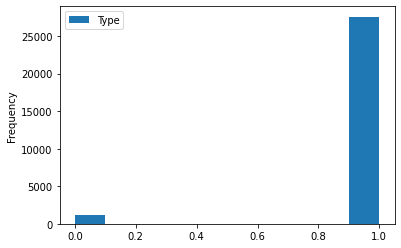

In [255]:
#plot the frequency of churn
types_new.plot.hist()

In [256]:
#combine to one dataframe
stat_new = types_new.merge(stat2, how = 'left', on = ['merchant', 'Year'])
stat_new = stat_new.merge(length, how = 'left', on = ['merchant', 'Year'])
stat_new = stat_new.merge(sum_season2, how = 'left', on = ['merchant', 'Year'])
stat_new = stat_new.merge(count_season2, how = 'left', on = ['merchant', 'Year'])
stat_new = stat_new.fillna(0)
stat_new.head()


,merchant,Year,Type,Mean,Median,Max,Min,Num,Std,Sum,Length,S1,S2,S3,S4,Num-S1,Num-S2,Num-S3,Num-S4
0,0002b63b92,2033-01-01,1.0,3379.000000,3379.0,3379.0,3379.0,1.0,0.000000,3379.0,1.0,0.0,3379.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0002b63b92,2034-01-01,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0002d07bba,2033-01-01,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0002d07bba,2034-01-01,1.0,22319.500000,21689.5,43842.0,2057.0,4.0,21568.589762,89278.0,3.0,0.0,0.0,0.0,89278.0,0.0,0.0,0.0,4.0
4,00057d4302,2033-01-01,1.0,1054.321429,752.0,4073.0,605.0,28.0,780.703911,29521.0,2.0,0.0,20386.0,9135.0,0.0,0.0,17.0,11.0,0.0


In [257]:
#create a new data frame for variables
title2 = ['merchant', 'Year', 'Type', 'Mean', 'Median', 'Max', 'Min', 'Num', 'Std', 'Sum', 'Length',
         'S1', 'S2', 'S3','S4', 'Num-S1', 'Num-S2', 'Num-S3', 'Num-S4']
dataset2 = pd.DataFrame(index=range(0, len(set(trans.merchant))*2),columns = title2)
dataset2 = dataset2.fillna(stat_new)
dataset2.head()
print(dataset2.isnull().sum())



merchant    0
Year        0
Type        0
Mean        0
Median      0
Max         0
Min         0
Num         0
Std         0
Sum         0
Length      0
S1          0
S2          0
S3          0
S4          0
Num-S1      0
Num-S2      0
Num-S3      0
Num-S4      0
dtype: int64


In [261]:
dataset2.groupby('Type').mean()

C:\Users\杯杯\AppData\Local\Temp\ipykernel_613360\1873472098.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  dataset2.groupby('Type').mean()


,Year,Mean,Median,Max,Min,Num,Std,Sum,Length,S1,S2,S3,S4,Num-S1,Num-S2,Num-S3,Num-S4
Type,,,,,,,,,,,,,,,,,
0.0,2033-07-14 04:43:11.747146496,18446.705769,13848.157594,146957.557507,3934.891133,545.398595,18268.348778,5.345094e+06,6.843723,632575.587357,993949.894644,1.394698e+06,2.323870e+06,71.006146,103.874451,140.374012,230.143986
1.0,2033-07-02 00:23:58.798389248,25604.292729,21789.130864,70550.853572,13115.031600,32.380728,15416.833743,6.295165e+05,2.541922,99065.256394,142690.484708,1.758715e+05,2.118892e+05,5.889308,7.491710,8.969452,10.030258


Some observations:
1. The average of the sum of amount, number of transactions of not churn merchant is higher, also the length of processing is longer,
but the mean, median, max, min is lower than churn. That is means, churn merchants have a shorter time to make the transaction, they make
a transaction for a higher value but the frequency is lower.
2. Not churn merchant always has small value transaction but use for a long time.
3. To prevent customer defection, the company can focus on some type of business.



<AxesSubplot:xlabel='labels'>

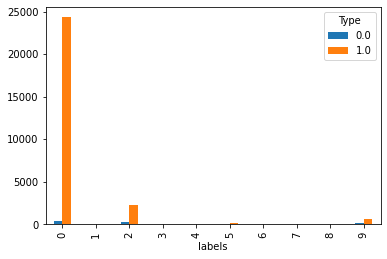

In [265]:
data_typed = dataset2.merge(dataset, how = 'left', on = 'merchant')
pd.crosstab(data_typed.labels, data_typed.Type).plot(kind='bar')


In [258]:
#randomly separate data into two set, 30% is test set, 70% is train set.
train_data = dataset2.sample(frac=0.7, random_state=25)
train_labels = pd.DataFrame(train_data.loc[:,'Type'])
train_labels = train_labels.astype('int')
test_data = dataset2.drop(train_data.index)
test_labels = test_data.loc[:,'Type']
test_labels = test_labels.astype('int')

In [259]:
#random forest classifier to predict the test data
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(train_data.iloc[:,3:], train_labels)
predictions = rf.predict(test_data.iloc[:,3:])

C:\Users\杯杯\AppData\Local\Temp\ipykernel_613360\1192307961.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data.iloc[:,3:], train_labels)


In [260]:
#calculate the accuracy of the model
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))


Accuracy: 0.9607478806178145
